In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score)
import seaborn as sns
from statsmodels.gam.api import GLMGam, BSplines
import statsmodels.api as sm
from statsmodels.gam.tests.test_penalized import df_autos

In [21]:
dfAll = pd.read_csv('train.csv')
df = dfAll[dfAll.stock_id == 2]

In [22]:
dfUse = df.copy()
dropping = ['stock_id', 'time_id', 'date_id', 'seconds_in_bucket']
dfUse.sort_index(level=['date_id', 'time_id'], inplace=True)
dfUse.drop(dropping, inplace=True, axis=1)
dfUse.set_index('row_id', inplace=True)
dfUse.fillna(0, inplace=True)

In [23]:
dfScaling = dfUse.copy()
# df.drop('Adj Close', inplace=True)
# X = dfScaling.drop('target', axis=1)
# X = dfScaling.drop(['target', 'imbalance_buy_sell_flag', 'far_price', 'near_price', 'bid_size', 'ask_size'], axis=1)
X = dfScaling.drop(['target'], axis=1)
y = dfScaling['target']
# dfScaling.drop(['imbalance_buy_sell_flag', 'far_price', 'near_price', 'bid_size', 'ask_size'], axis=1, inplace=True)
# dfScaling.drop(['imbalance_buy_sell_flag', 'far_price', 'near_price', 'bid_size', 'ask_size'], axis=1, inplace=True)

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
X = sc.fit_transform(X)
# training_set_scaled = np.concatenate((np.array(y.values), X), axis=1)
# training_set_scaled = np.hstack([y, X])
training_set_scaled = pd.DataFrame(np.hstack((X, np.array(y.values).reshape(-1, 1))), columns=dfScaling.columns)

# Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.005, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.005, random_state=42)

In [24]:
X_pred = X[-X_test.shape[0]:]
y_check = y[-y_test.shape[0]:]

In [25]:
from xgboost import XGBRegressor
xgb = XGBRegressor().fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_pred_sorted = xgb.predict(X_pred)

xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)
print(f'Mean Squared Error (MSE): {xgb_mse}')
print(f'Mean Absolute Error (MAE): {xgb_mae}')
print(f'R-squared (R2): {xgb_r2}')

xgb_mse_sorted = mean_squared_error(y_check, xgb_pred_sorted)
xgb_mae_sorted = mean_absolute_error(y_check, xgb_pred_sorted)
xgb_r2_sorted = r2_score(y_check, xgb_pred_sorted)
print(f'Mean Squared Error (MSE): {xgb_mse_sorted}')
print(f'Mean Absolute Error (MAE): {xgb_mae_sorted}')
print(f'R-squared (R2): {xgb_r2_sorted}')

Mean Squared Error (MSE): 102.20568957750076
Mean Absolute Error (MAE): 7.527203014976579
R-squared (R2): 0.25976947307278786
Mean Squared Error (MSE): 10.534147869050859
Mean Absolute Error (MAE): 2.553845447232442
R-squared (R2): 0.4721141535165574


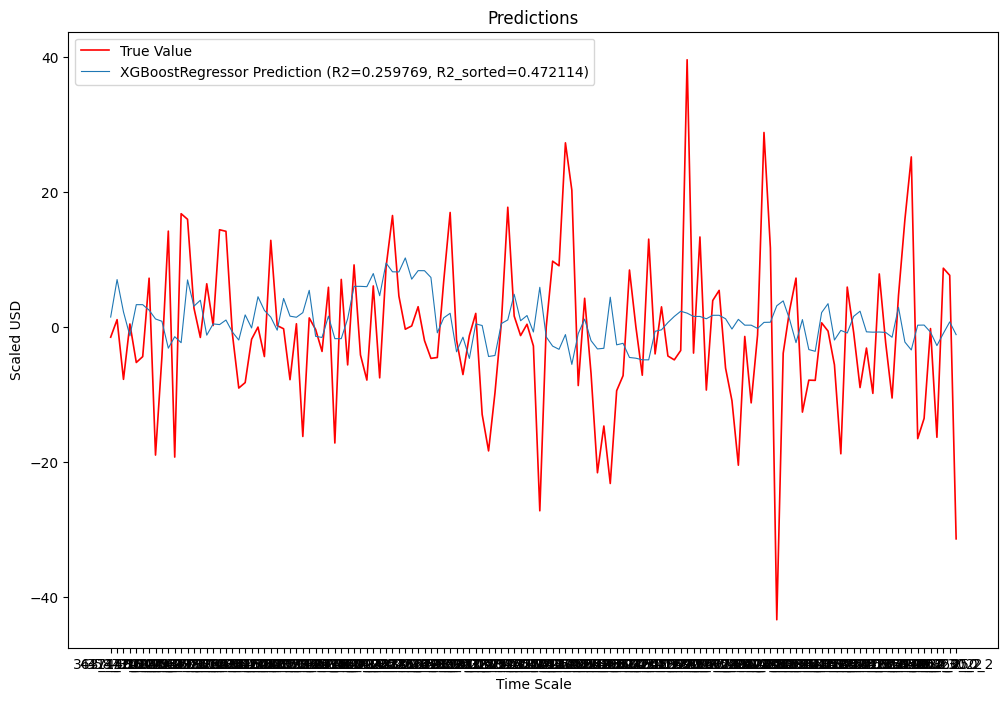

In [26]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True Value', color='red', linewidth=1.2)
plt.plot(xgb_pred_sorted, label=f'XGBoostRegressor Prediction (R2={xgb_r2:.6f}, R2_sorted={xgb_r2_sorted:.6f})', linewidth=0.8) 
plt.title('Predictions')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost
import optuna

In [28]:
# Define the model
model = xgboost.XGBRegressor()

# Fit the model
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [29]:
# Make predictions
y_pred = model.predict(X_test)

In [30]:
# Evaluate the model
print('MSE: ', mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))

MSE:  102.20568957750076
RMSE:  10.109682961275333


In [31]:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
# , missing=NaN,

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy=None, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=0, max_depth=6, max_leaves=None, min_child_weight=1,
             missing=nan, monotone_constraints='()', multi_strategy=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1, ...)

In [32]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model = xgboost.XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [33]:
# Create the study
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=100)

[I 2023-11-09 09:04:03,129] A new study created in memory with name: regression
[I 2023-11-09 09:04:03,774] Trial 0 finished with value: 3566.5729553616525 and parameters: {'max_depth': 5, 'learning_rate': 0.9054610012152562, 'n_estimators': 463, 'min_child_weight': 8, 'gamma': 0.8307964681972588, 'subsample': 0.2221796764117339, 'colsample_bytree': 0.7762960113980015, 'reg_alpha': 0.3142185363804425, 'reg_lambda': 0.4326975176695034, 'random_state': 358}. Best is trial 0 with value: 3566.5729553616525.
[I 2023-11-09 09:04:05,367] Trial 1 finished with value: 119.34158611534203 and parameters: {'max_depth': 7, 'learning_rate': 0.6221588372359929, 'n_estimators': 656, 'min_child_weight': 4, 'gamma': 0.5477099417376347, 'subsample': 0.7001696522944256, 'colsample_bytree': 0.1899238242059748, 'reg_alpha': 0.7042713603756714, 'reg_lambda': 0.31330509358722036, 'random_state': 909}. Best is trial 1 with value: 119.34158611534203.
[I 2023-11-09 09:04:10,335] Trial 2 finished with value: 246.

In [34]:
# Print the best parameters
print('Best parameters', study.best_params)

Best parameters {'max_depth': 8, 'learning_rate': 0.2663057315364943, 'n_estimators': 546, 'min_child_weight': 4, 'gamma': 0.08207951341335958, 'subsample': 0.9373337384858486, 'colsample_bytree': 0.8914285937364319, 'reg_alpha': 0.9432107471188267, 'reg_lambda': 0.7217795443541632, 'random_state': 83}


In [35]:
# Print the best value
print('Best value', study.best_value)

Best value 66.70967696449985


In [36]:
# Print the best trial
print('Best trial', study.best_trial)

Best trial FrozenTrial(number=91, state=1, values=[66.70967696449985], datetime_start=datetime.datetime(2023, 11, 9, 9, 9, 5, 869410), datetime_complete=datetime.datetime(2023, 11, 9, 9, 9, 8, 870637), params={'max_depth': 8, 'learning_rate': 0.2663057315364943, 'n_estimators': 546, 'min_child_weight': 4, 'gamma': 0.08207951341335958, 'subsample': 0.9373337384858486, 'colsample_bytree': 0.8914285937364319, 'reg_alpha': 0.9432107471188267, 'reg_lambda': 0.7217795443541632, 'random_state': 83}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'n_estimators': IntDistribution(high=1000, log=False, low=50, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'gamma': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.01, step=None), '

In [39]:
model = xgboost.XGBRegressor(**study.best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
op_pred = model.predict(X_pred)
# y_check

op_mse =  mean_squared_error(y_test, y_pred)
op_rmse =  np.sqrt(mean_squared_error(y_test, y_pred))
op_mae = mean_absolute_error(y_test, y_pred)
op_r2 = r2_score(y_test, y_pred)
print(f'MSE: {op_mse}')
print(f'RMSE: {op_rmse}')
print(f'Mean Absolute Error (MAE): {op_mae}')
print(f'R-squared (R2): {op_r2}')

op_mse_check =  mean_squared_error(y_check, op_pred)
op_rmse_check =  np.sqrt(mean_squared_error(y_check, op_pred))
op_mae_check = mean_absolute_error(y_check, op_pred)
op_r2_check = r2_score(y_check, op_pred)
print(f'MSE check: {op_mse_check}')
print(f'RMSE check: {op_rmse_check}')
print(f'Mean Absolute Error check (MAE): {op_mae_check}')
print(f'R-squared check (R2): {op_r2_check}')

MSE: 66.70967696449985
RMSE: 8.167599216691515
Mean Absolute Error (MAE): 6.248498027379059
R-squared (R2): 0.5168513657634348
MSE check: 0.7820657033159264
RMSE check: 0.8843447875777447
Mean Absolute Error check (MAE): 0.6729881965030486
R-squared check (R2): 0.9608092252992273


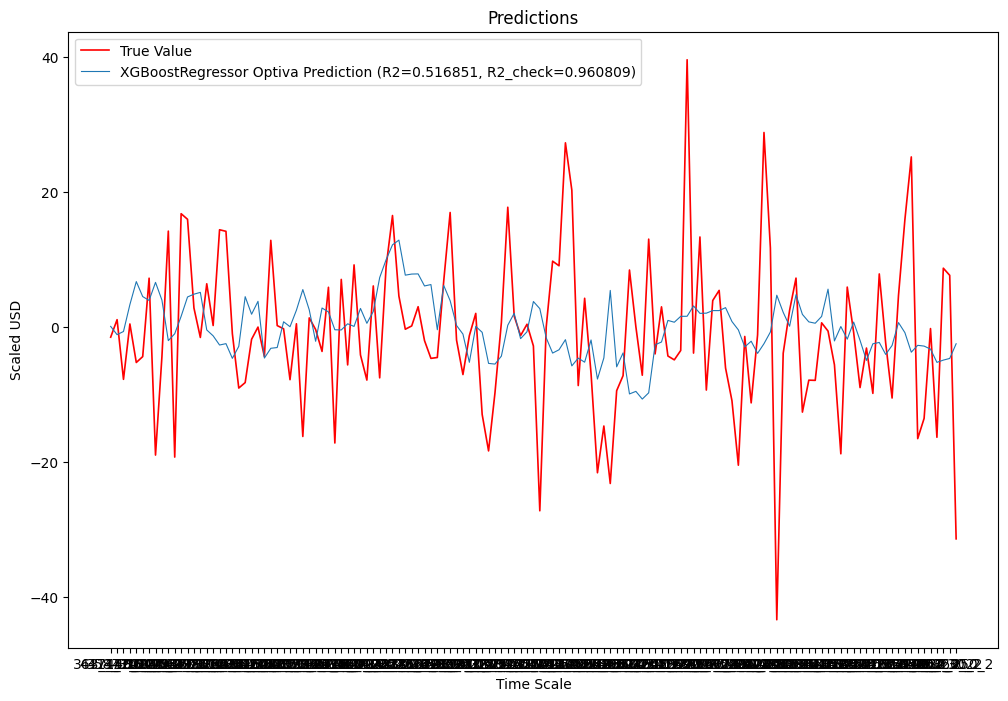

In [38]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True Value', color='red', linewidth=1.2)
plt.plot(op_pred, label=f'XGBoostRegressor Optiva Prediction (R2={op_r2:.6f}, R2_check={op_r2_check:.6f})', linewidth=0.8) 
# plt.plot(poly_pred, label=f'PolyLinReg Prediction (R2={poly_r2:.6f})', linewidth=0.8) 
plt.title('Predictions')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()